# Initialize and prepare data

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer
import matplotlib.pyplot as plt

In [ ]:
import time
import math
np.random.seed(43)

In [ ]:
# Follow tensorflow documentation to download and prepare data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)

print(x_train.shape[0], "train samples, before reduction")
print(x_test.shape[0], "test samples")

num_classes = 10
input_shape = (28, 28, 1)
# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

#make train- and valset out of 20, 100 instances respectively. Each class has 2 + 10 samples
x_train_indices = np.zeros(20)
x_val_indices = np.zeros(100)
for i in range(num_classes):
    idx = np.where(y_train[:,i]==1)[0]
    selected = np.random.choice(idx, size=12, replace=False)
    x_train_indices[i*2:i*2+2] = selected[:2]
    x_val_indices[i*10:i*10+10] = selected[2:]

x_train_new = x_train[x_train_indices.astype(int)]
y_train_new = y_train[x_train_indices.astype(int)]
x_val = x_train[x_val_indices.astype(int)]
y_val = y_train[x_val_indices.astype(int)]
X_p = np.delete(x_train, np.concatenate((x_train_indices, x_val_indices)).astype(int), axis=0)
y_p = np.delete(y_train, np.concatenate((x_train_indices, x_val_indices)).astype(int), axis=0)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples, before reduction
10000 test samples


In [ ]:
batch_size = 128
epochs = 30
acquired_points = 10
acquisition_times = 100
moG = 1

In [ ]:
sampling_steps = 5
mc_sampling = False
def nll(y, gaussian_preds):
  means = gaussian_preds[:, :, :, 0]
  vars = gaussian_preds[:, :, :, 1]

  if moG == 1: # This is just a Gaussian, easy to compute
    means = means[:, :, 0]
    vars = vars[:, :, 0] + 1e-5 * tf.ones_like(vars[:, :, 0])
    diff = ((y - means) ** 2) / vars + tf.math.log(2 * math.pi * vars)
    final_res = (0.5) * tf.reduce_sum(diff)
    return final_res
  else:
    d = tf.cast(tf.shape(means)[2], tf.float32)
    y = tf.expand_dims(y, axis=1)
    sq = tf.square(y - means, name="neg")

    log_gauss = -0.5 * (
        tf.reduce_sum(sq / vars, axis=2) +
        tf.reduce_sum(tf.math.log(vars), axis=2) +
        d * tf.math.log(2.0 * math.pi)
    )
    K = tf.cast(tf.shape(means)[1], tf.float32)
    log_prob = tf.reduce_logsumexp(log_gauss, axis=1) - tf.math.log(K)
    return log_prob

In [ ]:
sampling_steps = 5
mc_sampling = False
def nll_logvar(y, gaussian_preds):
  means = gaussian_preds[:, :, :, 0]
  log_vars = gaussian_preds[:, :, :, 1] + 1e-6 * tf.ones_like(gaussian_preds[:, :, :, 1])

  if moG == 1: # This is just a Gaussian, easy to compute
    means = means[:, :, 0]
    log_vars = log_vars[:, :, 0]
    diff = ((y - means) ** 2) / tf.math.exp(log_vars) + tf.math.log(2 * math.pi) + log_vars
    final_res = (0.5) * tf.reduce_sum(diff)
    return final_res
  else:
    d = tf.cast(tf.shape(means)[2], tf.float32)
    y = tf.expand_dims(y, axis=1)
    sq = tf.square(y - means, name="neg")

    log_gauss = -0.5 * (
        tf.reduce_sum(sq / tf.exp(vars), axis=2) +
        tf.reduce_sum(log_vars, axis=2) +
        d * tf.math.log(2.0 * math.pi)
    )
    K = tf.cast(tf.shape(means)[1], tf.float32)
    log_prob = tf.reduce_logsumexp(log_gauss, axis=1) - tf.math.log(K)
    return log_prob

In [ ]:
# model used in the paper
class CNN(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._forw = tf.keras.Sequential(
        [
            tf.keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(4, 4), activation="relu"),
            layers.Conv2D(32, kernel_size=(4, 4), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.25),
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
            ]
        )

    def call(self, x, **kwargs):
      return self._forw(x)


In [ ]:
def evaluate(x, y, loss_fn, model):
  y_pred = model(x)
  loss = loss_fn(y, y_pred)
  return loss

In [ ]:
def accuracy_classification(x, y, model):
  y_pred = model(x, training=False)
  y_pred = tf.argmax(y_pred, axis=-1)
  y = tf.argmax(y, axis=-1)
  return tf.reduce_mean(tf.cast(y_pred == y, dtype=tf.float32), axis=-1)

In [ ]:
def call_batchwise(fn, x, batch_size=164):
  return tf.concat([fn(x[i:i+batch_size]) for i in range(0, tf.shape(x)[0], batch_size)], axis=0)

In [ ]:
def max_entropy(T, model, x):
  #outputs = tf.zeros((x.shape[0], num_classes))
  outputs = model(tf.repeat(x, repeats=T, axis=0), training=True)
  outputs = tf.reduce_mean(tf.reshape(outputs, (-1, x.shape[0], num_classes)), axis=0)
  individual = outputs * tf.math.log(outputs + 1e-10)
  return -tf.reduce_sum(individual, axis=-1)

def bald(T, model, x):
  outputs = model(tf.repeat(x, repeats=T, axis=0), training=True)

  outputs_me = tf.reduce_mean(tf.reshape(outputs, (-1, tf.shape(x)[0], num_classes)), axis=0)
  individual = outputs_me * tf.math.log(outputs_me + 1e-10)
  me = -tf.reduce_sum(individual, axis=-1)

  outputs = outputs * tf.math.log(outputs + 1e-10)
  outputs = tf.reshape(outputs, (-1, tf.shape(x)[0], num_classes))
  outputs = tf.reduce_sum(outputs, axis=-1)
  outputs = -tf.reduce_mean(outputs, axis=0)
  return me - outputs

def var_ratios(T, model, x):
  #outputs = tf.zeros((x.shape[0], num_classes))
  #for _ in range(T):
    #output = model(x, training=True)
   # outputs += output
  #outputs = outputs / T
  outputs = model(tf.repeat(x, repeats=T, axis=0), training=True)
  outputs = tf.reduce_mean(tf.reshape(outputs, (-1, x.shape[0], num_classes)), axis=0)
  return 1 - tf.reduce_max(outputs, axis=-1)

def mean_std(T, model, x):
  #for i in range(T):
    #output = model(x, training=True)
    #outputs[:, i, :] = output
  outputs = tf.reshape(model(tf.repeat(x, repeats=T, axis=0), training=True), (-1, x.shape[0], num_classes))
  outputs = tf.transpose(outputs, [1, 0, 2])
  std = tf.math.sqrt(tf.math.reduce_variance(outputs, axis=1))
  return tf.reduce_mean(std, axis=-1)

def random(T, model, x):
  ind = tf.random.uniform([], maxval=tf.shape(x)[0], dtype=tf.int32)
  return tf.one_hot(ind, depth=tf.shape(x)[0])

acq_funs = {"bald": bald, "max_entropy": max_entropy, "var_ratios": var_ratios, "mean_std": mean_std, "random": random}

In [ ]:
def find_best_decay_local(x_train, y_train, x_val, y_val):
  weight_decays = [0, 1e-6, 5e-6, 1e-5, 1e-4]
  best_score = 0
  best_i = 0
  best_model = None
  for i, dec in enumerate(weight_decays):
    model = CNN()
    optim = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=dec)
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    model.compile(loss="categorical_crossentropy", optimizer=optim, metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, shuffle=True, verbose=0, callbacks=[callback])
    val_acc = accuracy_classification(x_val, y_val, model)
    #print(f"Scores in hyperparam opt {i}:", val_acc)
    if val_acc < best_score or i == 0:
      best_score = val_acc
      best_i = i
      best_model = model
  test_acc = accuracy_classification(x_test, y_test, best_model)
  return best_model, test_acc

# Global Decay Optimization

In [ ]:
# function that trains the current model on one train dataset in an intermediary stage of AL. For one acquisition function.
#returns the selected new sample indices from the pool and the loss
def train_once(x_train_cur, y_train_cur, acquisition_fn, model_curr, x_t, y_t, Xs, ys):
  model_curr.fit(x_train_cur, y_train_cur, batch_size=batch_size, epochs=epochs, shuffle=True, verbose=0)
  score = accuracy_classification(x_t, y_t, model_curr)
  acq_lambda = lambda x: acquisition_fn(100, model_curr, x)
  acq_scores = call_batchwise(acq_lambda, Xs)
  x_new = tf.nn.top_k(acq_scores, k=acquired_points).indices.numpy()
  return score, x_new

In [ ]:
from tqdm import tqdm
def train_full(acquisition_fn, x_t, y_t, Xs, ys, x_init_train, y_init_train, dec):
  scores = []
  x_train_cur = x_init_train.copy()
  y_train_cur = y_init_train.copy()
  for i in tqdm(range(acquisition_times)):
    model = CNN()
    optim = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=dec)
    model.compile(loss="categorical_crossentropy", optimizer=optim, metrics=["accuracy"])

    score, x_new = train_once(x_train_cur, y_train_cur, acquisition_fn, model, x_t, y_t, Xs, ys)
    x_train_cur = np.concat([x_train_cur, Xs[x_new]], axis=0)
    y_train_cur = np.concat([y_train_cur, ys[x_new]], axis=0)
    Xs = np.delete(Xs, x_new, axis=0)
    ys = np.delete(ys, x_new, axis=0)
    scores.append(score)

  model = CNN()
  optim = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=dec)
  model.compile(loss="categorical_crossentropy", optimizer=optim, metrics=["accuracy"])
  model.fit(x_train_cur, y_train_cur, batch_size=batch_size, epochs=epochs, shuffle=True, verbose=0)
  score = accuracy_classification(x_t, y_t, model)
  return tf.stack(scores, axis=0), model

In [ ]:
def find_best_decay(acquisition_fn):
  weight_decays = [1e-5, 1e-4, 1e-3]
  best_score = 0
  best_i = 0
  best_model = None
  for i, dec in enumerate(weight_decays):
    scores, model = train_full(acquisition_fn, x_val, y_val, x_train, y_train, x_train_new, y_train_new, dec)
    print(f"Scorse in hyperparam opt {i}:", scores[-1])
    if scores[-1] < best_score or i == 0:
      best_score = scores[-1]
      best_i = i
      best_model = model
  return best_i, best_score, best_model

In [ ]:
def train_acquisition(acquisition_fn):
  weight_decays = [1e-5, 1e-4, 1e-3]
  # Best decays: random: 0, var_ratios: 1, mean_std: 0, max_entropy: 0
  #best_i, best_score, best_model = find_best_decay(acquisition_fn)
  best_i = 0
  print(best_i)
  scores = []
  for i in range(3):
    score, model = train_full(acquisition_fn, x_test, y_test, x_train, y_train, x_train_new, y_train_new, weight_decays[best_i])
    scores.append(score)
    print(score)
    np.save(f"./{i}{str(acquisition_fn)}.npy", score.numpy())
  meaned_scores = tf.reduce_mean(tf.convert_to_tensor(scores), axis=0)

  return meaned_scores

In [ ]:

results = {}
for acq_fun in acq_funs:
  res = train_acquisition(acq_funs[acq_fun])
  print(res)
  np.save(f"./{str(acq_fun)}.npy", res.numpy())
  results[acq_fun] = res

0


 40%|████      | 40/100 [50:32<1:15:48, 75.80s/it]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
for res in results:
  plt.plot(results[res], label=res)
plt.legend()
plt.show()

# Local Decay Optimization

In [ ]:
def train_once_local_opt(x_train_cur, y_train_cur, acquisition_fn, Xs, ys):
  model_curr, test_score = find_best_decay_local(x_train_cur, y_train_cur, x_val, y_val)
  acq_lambda = lambda x: acquisition_fn(100, model_curr, x)
  acq_scores = call_batchwise(acq_lambda, Xs)
  x_new = tf.nn.top_k(acq_scores, k=acquired_points).indices.numpy()
  return test_score, x_new

In [ ]:
from tqdm import tqdm
def train_full_local(acquisition_fn, Xs, ys, x_init_train, y_init_train):
  scores = []
  x_train_cur = x_init_train.copy()
  y_train_cur = y_init_train.copy()
  for i in tqdm(range(acquisition_times)):
    score, x_new = train_once_local_opt(x_train_cur, y_train_cur, acquisition_fn, Xs, ys)
    x_train_cur = np.concat([x_train_cur, Xs[x_new]], axis=0)
    y_train_cur = np.concat([y_train_cur, ys[x_new]], axis=0)
    Xs = np.delete(Xs, x_new, axis=0)
    ys = np.delete(ys, x_new, axis=0)
    scores.append(score)

  model, score = find_best_decay_local(x_train_cur, y_train_cur, x_val, y_val)
  scores.append(score)
  return tf.stack(scores, axis=0), model

In [ ]:
import os
def train_acquisition_local(acq_name):
  scores = []
  for i in range(3):
    if os.path.exists(f"./{i}{str(acq_name)}_local.npy"):
      score = np.load(f"./{i}{str(acq_name)}_local.npy")
      print(len(score))
    else:
      score, model = train_full_local(acq_funs[acq_name], x_train, y_train, x_train_new, y_train_new)
      np.save(f"./{i}{str(acq_name)}_local.npy", score.numpy())
    scores.append(score)
    print(score)
  meaned_scores = tf.reduce_mean(tf.convert_to_tensor(scores), axis=0)

  return meaned_scores

In [ ]:
results_local = {}
for acq_fun in acq_funs:
  res = train_acquisition_local(acq_fun)
  print(res)
  np.save(f"./{str(acq_fun)}_local.npy", res.numpy())
  results_local[acq_fun] = res

101
[0.583  0.5673 0.646  0.6822 0.706  0.7353 0.7294 0.7435 0.7388 0.7395
 0.7397 0.5757 0.6947 0.7317 0.7524 0.7791 0.7525 0.7738 0.7975 0.7949
 0.7679 0.7934 0.8036 0.8006 0.7738 0.8008 0.8216 0.8407 0.8271 0.8326
 0.8446 0.8457 0.8406 0.8498 0.8467 0.8612 0.8641 0.8291 0.8553 0.8613
 0.8761 0.8641 0.8821 0.8614 0.8747 0.8722 0.8783 0.8772 0.8614 0.8769
 0.8753 0.8759 0.8847 0.887  0.8863 0.8861 0.8884 0.8919 0.8895 0.876
 0.8856 0.8913 0.8849 0.8946 0.89   0.8861 0.8921 0.8883 0.8855 0.8968
 0.8868 0.8947 0.8865 0.8916 0.8874 0.8632 0.8847 0.9028 0.8978 0.9016
 0.9045 0.9052 0.9068 0.8987 0.8957 0.8883 0.8959 0.902  0.9042 0.9107
 0.9008 0.9088 0.9148 0.8991 0.9057 0.9067 0.9061 0.9014 0.8809 0.8978
 0.9091]
101
[0.6434 0.6439 0.6605 0.6708 0.689  0.6848 0.6698 0.7111 0.7313 0.7271
 0.7326 0.5341 0.7006 0.7652 0.7829 0.7458 0.7741 0.8012 0.7808 0.7786
 0.7883 0.7981 0.8085 0.798  0.7337 0.7563 0.7964 0.7805 0.8125 0.806
 0.8233 0.8077 0.8121 0.805  0.8275 0.8263 0.8358 0.8249 0.835

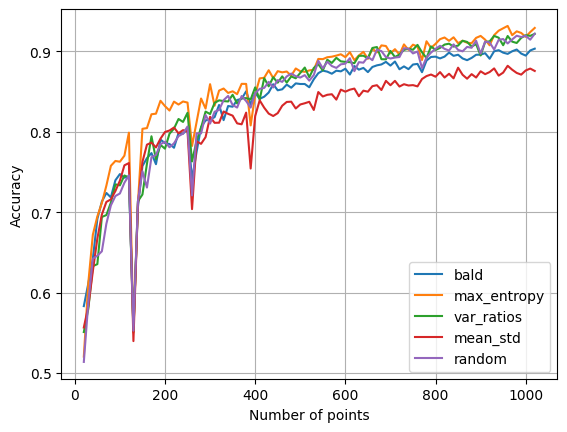

In [ ]:
steps = list(range(20, 20 + acquired_points * acquisition_times + 1, acquired_points))
for key in results_local:
  plt.plot(steps, results_local[key], label=key)
plt.grid()
plt.xlabel("Number of points")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("./local_acq_plot.svg")

# Importance of Model Uncertainty

In [ ]:
def deterministic_max_entropy(T, model, x):
  outputs = model(x, training=False)
  individual = outputs * tf.math.log(outputs + 1e-10)
  return -tf.reduce_sum(individual, axis=-1)

def deterministic_bald(T, model, x):
  me = deterministic_max_entropy(1, model, x)
  outputs = model(x, training=False)
  outputs = outputs * tf.math.log(outputs + 1e-10)
  outputs = -tf.reduce_sum(outputs, axis=-1)
  return me - outputs

def deterministic_var_ratios(T, model, x):
  outputs = model(x, training=False)
  return 1 - tf.reduce_max(outputs, axis=-1)

In [ ]:
acq_funs = {"deterministic_max_entropy": deterministic_max_entropy, "deterministic_bald": deterministic_bald, "deterministic_var_ratios": deterministic_var_ratios}
results = {}
for acq_fun in acq_funs:
  res = train_acquisition(acq_funs[acq_fun])
  print(res)
  np.save(f"./{str(acq_fun)}.npy", res.numpy())
  results[acq_fun] = res

In [ ]:
acq_funs = {"deterministic_max_entropy": deterministic_max_entropy, "deterministic_bald": deterministic_bald, "deterministic_var_ratios": deterministic_var_ratios}
results_local_det = {}
for acq_fun in acq_funs:
  res = train_acquisition_local(acq_funs[acq_fun])
  print(res)
  np.save(f"./{str(acq_fun)}_local.npy", res.numpy())
  results_local_det[acq_fun] = res

[0.5403 0.5151 0.5463 0.5799 0.5436 0.6258 0.6507 0.6234 0.6823 0.6577
 0.6479 0.3656 0.4937 0.5583 0.6298 0.6612 0.6887 0.6991 0.687  0.7137
 0.7381 0.721  0.7501 0.7675 0.641  0.7477 0.7639 0.8049 0.8127 0.7704
 0.8029 0.8018 0.8246 0.803  0.8231 0.8292 0.8519 0.7454 0.7922 0.8507
 0.8299 0.8514 0.8458 0.8339 0.8559 0.8442 0.8581 0.846  0.8806 0.8617
 0.8398 0.8818 0.8964 0.8901 0.913  0.8869 0.8972 0.9013 0.9124 0.9069
 0.8915 0.9201 0.9267 0.8972 0.9186 0.8919 0.9336 0.9319 0.92   0.9383
 0.9357 0.9217 0.9425 0.9462 0.9452 0.9157 0.9442 0.9478 0.9467 0.9422
 0.9527 0.941  0.9514 0.9556 0.9563 0.9574 0.9608 0.9514 0.9329 0.9567
 0.9583 0.9567 0.9583 0.9681 0.9632 0.9615 0.969  0.9638 0.9683 0.9665
 0.9686]
[0.5043 0.5836 0.7028 0.7123 0.7283 0.7606 0.7401 0.7129 0.7143 0.7174
 0.7354 0.6209 0.6238 0.7552 0.7283 0.7664 0.7681 0.7633 0.7742 0.7955
 0.7934 0.7774 0.7862 0.7844 0.7374 0.7847 0.8214 0.8138 0.7992 0.8243
 0.8126 0.7925 0.81   0.8201 0.838  0.8143 0.8318 0.8086 0.8391 0.84

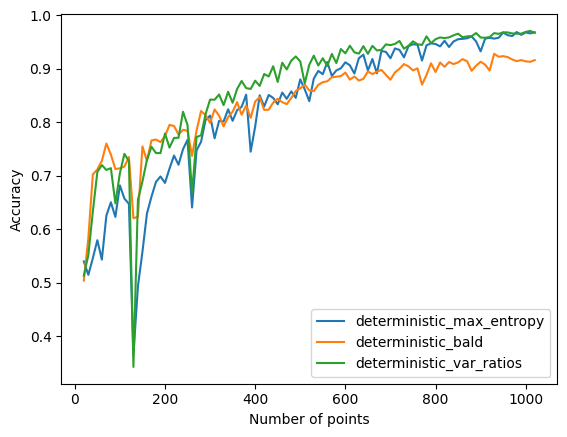

In [ ]:
steps = list(range(20, 20 + acquired_points * acquisition_times + 1, acquired_points))
for key in results_local_det:
  plt.plot(steps, results_local_det[key], label=key)
plt.xlabel("Number of points")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("./det_acq_plot.svg")

# Analytic Inference

In [ ]:
#This is actually treated as the std
weights_prior_var = 0.01
# This implies that the covariance matrix of each W_i is diag(weights_prior_var^2), ..., weights_prior_var^2)
sigma_1_inv = tf.linalg.diag(tf.ones(128) * (1.0 / (weights_prior_var ** 2)))

In [ ]:

# The model for the regression. Might be better to replace the softmax in the last layer to something that outputs values outside of the [0, 1] range.
class HierarchicalRegressor(tf.keras.Model):
  def __init__(self, weights_prior=weights_prior_var, **kwargs):
    super().__init__(**kwargs)
    self._cnn = tf.keras.Sequential(
      [
          layers.Conv2D(32, kernel_size=(4, 4), activation="relu"),
          layers.Conv2D(32, kernel_size=(4, 4), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Flatten(),
          layers.Dropout(0.25),
          layers.Dense(128, activation="relu")
          ]
      )
    self._regression_layer = layers.Dense(10, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=weights_prior))

  def freeze(self):
    self._cnn.trainable = False

  def unfreeze(self):
    self._cnn.trainable = True

  def call(self, x, **kwargs):
    x = self._cnn(x)
    return self._regression_layer(x)

In [ ]:
def compute_pred_cov(sigma_2, model, x, blocks_of_cov_post):
    y_ast = model(x)
    V_pred = tf.transpose(tf.einsum('bd,kde,be->kb', y_ast, blocks_of_cov_post, y_ast))
    sig_exp = tf.repeat(sigma_2, tf.shape(V_pred)[0], axis=0)
    return V_pred + tf.reshape(sig_exp, (tf.shape(V_pred)[0], -1))

In [ ]:
def compute_pred_mean(model, x, posterior_mean):
    y_ast = model(x, training=False)
    M_pred = tf.matmul(y_ast, tf.reshape(posterior_mean, (tf.shape(posterior_mean)[0], tf.shape(posterior_mean)[1])), transpose_b=True)
    return M_pred

In [ ]:
import tensorflow as tf
import numpy as np

class BayesianLastLayerModel(tf.keras.Model):
    def __init__(self, compute_posterior_mean, compute_posterior_cov, feat_extractor, sigma2, output_dim=10, feature_dim=128, **kwargs):
        super().__init__(**kwargs)

        self.feature_extractor = feat_extractor

        self.feature_dim = feature_dim
        self.output_dim = output_dim

        self.M_ast = tf.zeros((output_dim, feature_dim))
        self.V_ast = (weights_prior_var ** 2) * tf.reshape(tf.repeat(tf.eye(feature_dim), output_dim, axis=0), (output_dim, feature_dim, feature_dim))
        self.compute_posterior_mean = compute_posterior_mean
        self.compute_posterior_cov = compute_posterior_cov
        self.sigma2 = sigma2

    def estimate_sigma_2(self, X, Y):
      y_pred = self.feature_extractor(X)
      #ast_pred = tf.matmul(self.M_ast, y_pred, transpose_b=True)
      #return tf.reduce_sum(tf.cast(tf.transpose(Y), ast_pred.dtype) - ast_pred, axis=1)

      N = tf.cast(tf.shape(y_pred)[0], tf.float32)

      M = self.M_ast
      S = self.V_ast

      D = tf.shape(y_pred)[1]  # feature_dim
      K = tf.shape(Y)[1]       # output_dim

      # (K, N)
      mult = tf.matmul(M, y_pred, transpose_b=True)

      # explicit, safe transpose
      Yt = tf.cast(tf.transpose(Y, perm=[1, 0]), mult.dtype)  # (K, N)
      R = Yt - mult                                           # (K, N)
      # (K,)
      rss = tf.reduce_sum(tf.square(R), axis=1)

      # (D, D)
      C = tf.matmul(y_pred, y_pred, transpose_a=True)
      # (K,)
      trace_terms = tf.linalg.trace(tf.matmul(S, C))

      self.sigma2 = (rss + trace_terms) / N
      return self.sigma2

    def fit_posterior(self, X, Y):
        #self.estimate_sigma_2(X, Y)
        self.M_ast = tf.reshape(self.compute_posterior_mean(1, self.feature_extractor, X, Y, self.sigma2), (self.output_dim, self.feature_dim))
        v_ast_blocks = self.compute_posterior_cov(1, self.feature_extractor, X, Y, self.sigma2)
        if type(v_ast_blocks) == list:
          self.V_ast = tf.stack(v_ast_blocks)
        else: # is already stacked tensor
          self.V_ast = v_ast_blocks

    def sample_y_pred(self, x):
        """
        Draw y ~ N(M_pred, V_pred) V_pred is diagonal following the proof from the paper. This expects to have M_ast, V_ast already computed for the given X, Y.
        """
        M_hat = compute_pred_mean(self.feature_extractor, x, self.M_ast)
        V_hat = compute_pred_cov(self.sigma2, self.feature_extractor, x, self.V_ast)
        epsilon = tf.random.normal((5,  tf.shape(V_hat)[0], tf.shape(V_hat)[1]))

        V_rep = tf.repeat(tf.expand_dims(tf.math.sqrt(V_hat), 0), 5, axis=0)
        y_hat = M_hat + tf.reduce_sum(V_rep * epsilon, axis=0)
        return y_hat

        y_hat = tf.random.normal(tf.shape(M_hat), mean=M_hat, stddev=tf.math.sqrt(V_hat))
        return y_hat

    def call(self, x, training=False):
        sample = self.sample_y_pred(x)
        return sample


## variational inference methods

In [ ]:
import time
def posterior_mean_mfvi_diag(T, model, X, Y, sigma_2):
  y_pred = model(X, training=False)

  p_t_p = tf.matmul(y_pred, y_pred, transpose_a=True)
  p_t_y = tf.matmul(y_pred, Y, transpose_a=True)
  m_ast = []
  for i in range(10):
    reg = (sigma_2[i] / (weights_prior_var ** 2)) * tf.eye(y_pred.shape[1])
    m_i_ast = tf.linalg.solve(reg + p_t_p, p_t_y[:,i:i+1])
    m_ast.append(m_i_ast)

  M_ast = tf.stack(m_ast)
  return M_ast

In [ ]:
import time
def posterior_mean_mfvi_full(T, model, X, Y, sigma_2):
  y_pred = model(X, training=False)

  n, K = y_pred.shape
  d = Y.shape[1]
  A = tf.matmul(y_pred, y_pred, transpose_a=True)
  C = tf.matmul(y_pred, Y, transpose_a=True)
  b = sigma_2 / (weights_prior_var ** 2)

  M_cols = []
  for i in range(d):
      Ai = A + b[i] * tf.eye(K)
      rhs_i = C[:, i:i+1]
      sol_i = tf.linalg.solve(Ai, rhs_i)
      M_cols.append(sol_i)

  M_star = tf.concat(M_cols, axis=1)
  return M_star

In [ ]:
def posterior_cov_mfvi_full(T, model, X, Y, sigma_2):
    y_pred = model(X, training=False)

    p_p_t = tf.matmul(y_pred, y_pred, transpose_a=True)
    p_t_y = tf.matmul(y_pred, Y, transpose_a=True)

    V_I_r = [] # only keep the block matrices on the diagonal. Rest is 0. Do not explicitly turn it into matrix
    for i in range(tf.shape(sigma_2)[0]):
        A_i = p_p_t * (1 / sigma_2[i]) + (1 / weights_prior_var ** 2) * tf.eye(tf.shape(p_p_t)[0])
        V_I_r.append(tf.linalg.inv(A_i))
    return V_I_r

In [ ]:
def posterior_cov_mfvi_diag(T, model, X, Y, sigma_2):
    y_pred = model(X, training=False)
    phi_r = tf.reduce_sum(y_pred ** 2, axis=0)

    # broadcast across sigma_i
    denom = phi_r[tf.newaxis, :] / tf.square(sigma_2)[:, tf.newaxis] \
            + 1.0 / tf.square(weights_prior_var)

    V_ast = tf.math.reciprocal(denom)
    V_ast = tf.linalg.diag(V_ast)
    return V_ast

In [ ]:
def posterior_cov_ai(T, model, X, Y, sigma_2):
  y_pred = model(X, training=False)
  sigmas_prime = []
  for i in range(num_classes):
    sigmas_prime_i = tf.linalg.inv((1 / (weights_prior_var ** 2)) * tf.eye(tf.shape(y_pred)[1]) + (1 / sigma_2[i]) * tf.matmul(y_pred, y_pred, transpose_a=True))
    sigmas_prime.append(sigmas_prime_i)
  return tf.stack(sigmas_prime, axis=0)

In [ ]:
def posterior_mean_ai(T, model, X, Y, sigma_2):
  y_pred = model(X, training=False)
  sigmas_prime = posterior_cov_ai(T, model, X, Y, sigma_2)
  PhiY = tf.matmul(y_pred, Y, transpose_a=True)

  scale = tf.math.reciprocal(sigma_2)
  PhiY_scaled = PhiY * scale[tf.newaxis, :]

  # mu_i = Sigma_i @ rhs_i
  mu_prime = tf.einsum('mdk,km->md', sigmas_prime, PhiY_scaled)
  return mu_prime

In [ ]:
def pred_variance_ai(T, model, x, X, Y, sigma_2):
  y_pred = model(X, training=False)
  y_ast = model(x, training=False)
  # one could leave sigma2 out of the sigma_pred as this does not influence the argmin

  sigma_pred = tf.ones(tf.shape(x)[0]) * tf.reduce_sum(sigma_2, axis=-1)
  for i in range(num_classes):
    sigmas_prime_i = tf.linalg.inv((1 / (weights_prior_var ** 2)) + (1 / sigma_2[i]) * tf.matmul(y_pred.T, y_pred))
    sigma_pred += tf.reduce_sum(y_ast * tf.matmul(y_ast, sigmas_prime_i), axis=1) # directly sum up here because sigma_ast has only sigmas_prime_i's in the diag.
  return sigma_pred

## Pipeline VI

In [ ]:
vi_acq_functions = {"analytical_inference": (posterior_mean_ai, posterior_cov_ai), "mfvi_full": (posterior_mean_mfvi_full, posterior_cov_mfvi_full), "mfvi_diag": (posterior_mean_mfvi_diag, posterior_cov_mfvi_diag)}

In [ ]:
def rmse_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    return tf.sqrt(mse)

In [ ]:
def find_best_decay_local_cnn(x_train, y_train, x_val, y_val):
  weight_decays = [0, 1e-6, 5e-6, 1e-5, 1e-4]
  best_score = 0
  best_i = 0
  best_model = None
  for i, dec in enumerate(weight_decays):
    cnn_model = HierarchicalRegressor()
    optim = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=dec)
    cnn_model.compile(loss=rmse_loss, optimizer=optim)
    cnn_model.fit(x_train, y_train, batch_size=batch_size, epochs=50, shuffle=True, verbose=0)
    val_acc = evaluate(x_val, y_val, tf.keras.metrics.RootMeanSquaredError(), cnn_model)
    #print(f"Scores in hyperparam opt {i}:", val_acc)
    if val_acc < best_score or i == 0:
      best_score = val_acc
      best_i = i
      best_model = cnn_model
  return best_model

In [ ]:
def fit_pv(x_train_n, y_train_n, model: BayesianLastLayerModel):
    model.fit_posterior(x_train_n, y_train_n)
    return evaluate(x_test, y_test, tf.keras.metrics.RootMeanSquaredError(), model)


In [ ]:
def compute_var(T, model: BayesianLastLayerModel, x):
    V_ast = model.V_ast
    sigma2 = model.sigma2
    covs = compute_pred_cov(sigma2, model.feature_extractor, x, V_ast)
    return tf.reduce_sum(covs, axis=-1)

In [ ]:
from itertools import product
def find_data_variance_hyperparam(x_train_cur, y_train_cur, cnn_layer, post_mean_fn, post_cov_fn):
  data_variances = [0.05, 0.02]
  combinations = list(product(data_variances, repeat=y_train_cur.shape[-1]))
  best_model = None
  best_loss = None
  for sigmas in combinations:
    model_wrapper = BayesianLastLayerModel(post_mean_fn, post_cov_fn, cnn_layer, tf.convert_to_tensor(sigmas))
    model_wrapper.fit_posterior(x_train_cur, y_train_cur)
    score = evaluate(x_val, y_val, tf.keras.metrics.RootMeanSquaredError(), model_wrapper)
    if best_loss is None or score < best_loss:
      best_model = model_wrapper
      best_loss = score
  test_score = evaluate(x_test, y_test, tf.keras.metrics.RootMeanSquaredError(), best_model)
  return best_model, test_score


In [ ]:
def train_once_local_pred_var(x_train_cur, y_train_cur, acquisition_fn, Xs, ys, cnn_layer, post_mean_fn, post_cov_fn):
  model, test_score = find_data_variance_hyperparam(x_train_cur, y_train_cur, cnn_layer, post_mean_fn, post_cov_fn)
  acq_lambda = lambda x: compute_var(100, model, x)
  acq_scores = call_batchwise(acq_lambda, Xs)
  x_new = tf.nn.top_k(acq_scores, k=acquired_points).indices.numpy()
  return test_score, x_new

In [ ]:
from tqdm import tqdm
def train_full_local_pv(acq_name, Xs, ys, x_init_train, y_init_train, cnn_layer):
    post_mean_fn = vi_acq_functions[acq_name][0]
    post_cov_fn = vi_acq_functions[acq_name][1]
    scores = []
    x_train_cur = x_init_train.copy()
    y_train_cur = y_init_train.copy()
    for i in tqdm(range(acquisition_times)):
        score, x_new = train_once_local_pred_var(x_train_cur, y_train_cur, acq_name, Xs, ys, cnn_layer, post_mean_fn, post_cov_fn)
        x_train_cur = np.concat([x_train_cur, Xs[x_new]], axis=0)
        y_train_cur = np.concat([y_train_cur, ys[x_new]], axis=0)
        Xs = np.delete(Xs, x_new, axis=0)
        ys = np.delete(ys, x_new, axis=0)
        scores.append(score)

    model, score = find_data_variance_hyperparam(x_train_cur, y_train_cur, cnn_layer, post_mean_fn, post_cov_fn)
    scores.append(score)
    return tf.stack(scores, axis=0), model

In [ ]:
import os
def train_acquisition_local_pv(acq_name):
    print("Start fitting model")
    if os.path.exists("./cnn_mod.keras"):
      cnn_mod = tf.keras.models.load_model(
          "./cnn_mod.keras",
          custom_objects={"HierarchicalRegressor": HierarchicalRegressor,
                          "rmse_loss": rmse_loss},
      )
    else:
      cnn_mod = find_best_decay_local_cnn(x_train, y_train, x_val, y_val)
      cnn_mod.save("./cnn_mod.keras")
    cnn_layer = cnn_mod._cnn
    print("Model fitted")
    scores = []
    for i in range(3):
      if os.path.exists(f"./{i}{str(acq_name)}.npy"):
        score = np.load(f"./{i}{str(acq_name)}.npy")
        print(len(score))
      else:
        score, model = train_full_local_pv(acq_name, X_p, y_p, x_train_new, y_train_new, cnn_layer)
        np.save(f"./{i}{str(acq_name)}.npy", score.numpy())
        print(score)
      scores.append(score)
    meaned_scores = tf.reduce_mean(tf.convert_to_tensor(scores), axis=0)

    return meaned_scores

In [ ]:
results_local_vi = {}
for acq_fun in vi_acq_functions:
  res = train_acquisition_local_pv(acq_fun)
  print(res)
  np.save(f"./{str(acq_fun)}_local.npy", res.numpy())
  results_local_vi[acq_fun] = res

Start fitting model
Model fitted


100%|██████████| 100/100 [3:23:05<00:00, 121.85s/it]


tf.Tensor(
[0.42836425 0.41839004 0.41335893 0.41168362 0.40795258 0.40263027
 0.40266675 0.39993802 0.39804754 0.3978687  0.39556864 0.3923581
 0.3902974  0.38521716 0.38615158 0.3853111  0.38563743 0.3811448
 0.38100278 0.38048282 0.37830076 0.39843845 0.3755448  0.37616268
 0.37050018 0.3941869  0.3689567  0.39096743 0.36882317 0.36920124
 0.36613894 0.36551195 0.36466596 0.3638991  0.3628333  0.3606812
 0.362384   0.35994253 0.37919995 0.35958064 0.35882765 0.35505927
 0.3795589  0.35470176 0.3543169  0.35483164 0.35418105 0.35208276
 0.352067   0.37117073 0.3516719  0.35029864 0.35018316 0.3508187
 0.34800586 0.34707847 0.34789276 0.34869638 0.3477591  0.34637097
 0.3470114  0.36877367 0.34606758 0.36948267 0.34446368 0.34425858
 0.34492105 0.34478065 0.36549056 0.3432415  0.34268436 0.36676493
 0.34225366 0.3407853  0.34124097 0.3668716  0.34108225 0.34027284
 0.34103188 0.362995   0.34114516 0.36131847 0.33919102 0.3405258
 0.34048438 0.3384783  0.3392798  0.33911896 0.33921295 

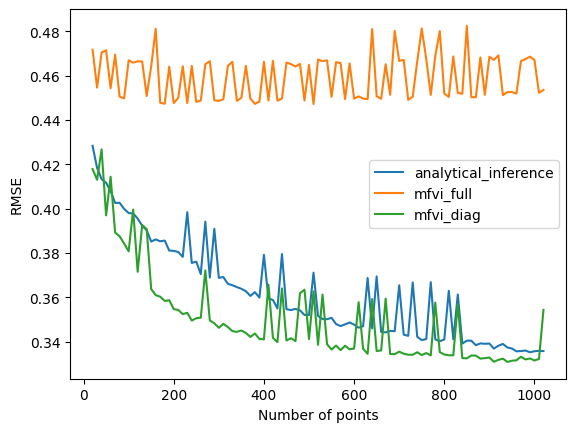

In [ ]:
steps = list(range(20, 20 + acquired_points * acquisition_times + 1, acquired_points))
for key in results_local_vi:
  plt.plot(steps, results_local_vi[key], label=key)
plt.xlabel("Number of points")
plt.ylabel("RMSE")
plt.legend()
plt.savefig("./vi_acq_plot.svg")

# CNP for pred variance

In [ ]:
moG = 1
class CNPModel(tf.keras.Model):
  def __init__(self, observations, output_dim=10, moG=moG, **kwargs):
    super().__init__(**kwargs)
    self.moG = moG
    self.squeezing_layer = layers.Reshape((observations, 28, 28))
    self.observations = observations
    self.output_dim = output_dim

    # Each sample should have concatenated X and y
    self.context_concat = layers.Concatenate(axis=-1, name="conc")
    self.pooling = layers.AveragePooling2D(pool_size=(2, 2), data_format="channels_first")
    self.x_obs_dim_reduction = tf.keras.Sequential([
        layers.Reshape((observations, -1)),
        layers.Dense(20, activation="relu")
    ], name="obs_red")
    self.all_obs_dim_reduction = layers.Dense(20, activation="relu", name="obs_all")

    self._query_red = tf.keras.Sequential(
        [
          layers.Conv2D(32, kernel_size=(4, 4), activation="relu"),
          layers.Conv2D(8, kernel_size=(4, 4), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Flatten(),
          layers.Dense(40),
          layers.Reshape((2, 20))
        ], name="q_red"
    )

    self._obs_att = layers.MultiHeadAttention(num_heads=3, key_dim=20, name="obs_att")
    self._cross_att = layers.MultiHeadAttention(num_heads=3, key_dim=20, name="cross_att")

    self._forw = tf.keras.Sequential(
    [
        layers.Flatten(),
        layers.Dense(num_classes * moG * 2, activation="relu"),
        layers.Reshape((num_classes, moG, 2)),
        ], name="last_layer"
    )

  def call(self, z, **kwargs):
    """
    for each output logit, and each gaussian mixture component there is a tuple (mean, sigma)
    """
    (x, X, Y) = z
    X = self.squeezing_layer(X)
    X_red = self.pooling(X)
    X_red = self.x_obs_dim_reduction(X)
    concatted = self.context_concat([X_red, Y])
    obs = self.all_obs_dim_reduction(concatted)
    obs = self._obs_att(key=obs, query=obs, value=obs)
    x_red = self._query_red(x)
    cross = self._cross_att(query=x_red, value=obs)
    mogs = self._forw(cross)
    return mogs

  def get_config(self):
    base_config = super().get_config()
    return {
        **base_config,
        "observations": self.observations,
        "output_dim": self.output_dim,
        "moG": self.moG,
    }
  @classmethod
  def from_config(cls, config):
      return cls(**config)

In [ ]:
# TODO: Fix model, needs an attention layer for the observations X, Y
class CNPInferenceModel(tf.keras.Model):
  def __init__(self, np_model: CNPModel):
    super().__init__()
    self.np_model = np_model

  def call(self, z, **kwargs):
    (x, X, Y) = z
    mogs = self.np_model(z)
    eps = tf.random.normal((tf.shape(x)[0], tf.shape(mogs)[1], tf.shape(mogs)[2]))
    means = mogs[:, :, :, 0]
    vars = mogs[:, :, :, 1]
    return tf.reduce_sum(means + tf.math.sqrt(vars) * eps, axis=-1)

In [ ]:
def cnp_acquisition_fn(T, model, x, X, Y):
  mog = model((x, X, Y))
  return tf.reduce_sum(tf.reduce_sum(mog[:, :, :, 1], axis=-1), axis=-1)

In [ ]:
def call_batchwise_cnp_acq(model, x, X, Y, batch_size=164):
  X_exp = tf.repeat(tf.expand_dims(X, axis=0), repeats=batch_size, axis=0)
  Y_exp = tf.repeat(tf.expand_dims(Y, axis=0), repeats=batch_size, axis=0)
  return tf.concat([cnp_acquisition_fn(1, model, x[i:i+batch_size], X_exp[:(tf.shape(x)[0] - i)], Y_exp[:(tf.shape(x)[0] - i)]) for i in range(0, tf.shape(x)[0], batch_size)], axis=0)

In [ ]:
def evaluate_cnp(model, x, y, X, Y, batch_size=164):
  X_exp = tf.repeat(tf.expand_dims(X, axis=0), repeats=batch_size, axis=0)
  Y_exp = tf.repeat(tf.expand_dims(Y, axis=0), repeats=batch_size, axis=0)
  y_hat = tf.concat([model((x[i:i+batch_size], X_exp[:(tf.shape(x)[0] - i)], Y_exp[:(tf.shape(x)[0] - i)])) for i in range(0, tf.shape(x)[0], batch_size)], axis=0)
  return tf.keras.metrics.RootMeanSquaredError()(y, y_hat)

In [ ]:
def get_train_samples(x_set, y_set):
  # Create 10 x train_size samples (x, X, Y), y
  train_size = x_set.shape[0]
  K = train_size - 1
  X_new = np.zeros(((10 * train_size, K,) + x_set.shape[1:]))
  Y_new = np.zeros((10 * train_size, K, y_set.shape[1]))
  x_new = np.zeros(((10 * train_size,) + x_set.shape[1:]))
  y_new = np.zeros((10 * train_size, y_set.shape[1]))
  for i in range(10 * train_size):
    inds = np.random.choice(train_size, size=K + 1, replace=False)
    X_new[i], Y_new[i] = x_set[inds[:-1]], y_set[inds[:-1]]
    x_new[i] = x_set[inds[-1]]
    y_new[i] = y_set[inds[-1]]

  return tf.data.Dataset.from_tensor_slices(((x_new, X_new, Y_new), y_new))

In [ ]:
def find_best_decay_cnp(x_train, y_train, x_val, y_val):
  weight_decays = [0, 1e-6, 1e-5, 1e-4]
  best_score = 0
  best_i = 0
  best_model = None

  used_this_round = np.random.choice(x_train.shape[0], size=x_train.shape[0] - 1, replace=False)
  for i, dec in enumerate(weight_decays):
    np_model = CNPModel(tf.shape(x_train)[0].numpy() - 1)
    optim = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=dec)
    np_model.compile(loss=nll, optimizer=optim)
    train_set = get_train_samples(x_train, y_train)
    train_set = train_set.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    np_model.fit(train_set, epochs=epochs, shuffle=True, verbose=0)
    model = CNPInferenceModel(np_model)


    X_exp = tf.repeat(tf.expand_dims(x_train[used_this_round], axis=0), repeats=y_val.shape[0], axis=0)
    Y_exp = tf.repeat(tf.expand_dims(y_train[used_this_round], axis=0), repeats=y_val.shape[0], axis=0)
    val_acc = evaluate((x_val, X_exp, Y_exp), y_val, tf.keras.metrics.RootMeanSquaredError(), model)
    if val_acc < best_score or i == 0:
      best_score = val_acc
      best_i = i
      best_model = np_model


  test_acc = evaluate_cnp(CNPInferenceModel(best_model), x_test, y_test, x_train[used_this_round], y_train[used_this_round], batch_size=512)
  #test_acc = evaluate((x_test, X_exp, Y_exp), y_test, tf.keras.metrics.RootMeanSquaredError(), NPInferenceModel(best_model))
  return best_model, test_acc

In [ ]:
import os
def train_once_local_opt_cnp(x_train_cur, y_train_cur, Xs, ys, i):
  if os.path.exists(f"./cnp_model_new_{i}.keras"):
    model_curr = tf.keras.models.load_model(
        f"./cnp_model_new_{i}.keras",
        custom_objects={"CNPModel": CNPModel, "nll": nll},
    )
    get_train_samples(x_train_cur, y_train_cur)# to get the same seed cycle in numpy
    used_this_round = np.random.choice(x_train_cur.shape[0], size=x_train_cur.shape[0] - 1, replace=False)
    test_score = evaluate_np(CNPInferenceModel(model_curr), x_test, y_test, x_train[used_this_round], y_train[used_this_round])
  else:
    model_curr, test_score = find_best_decay_np(x_train_cur, y_train_cur, x_val, y_val)
    model_curr.save(f"./cnp_model_new_{i}.keras")
  print(str(i), test_score)
  used_this_round = np.random.choice(x_train_cur.shape[0], size=x_train_cur.shape[0] - 1, replace=False)
  acq_scores = call_batchwise_cnp_acq(model_curr, Xs, x_train_cur[used_this_round], y_train_cur[used_this_round], batch_size=512)
  x_new = tf.nn.top_k(acq_scores, k=acquired_points).indices.numpy()
  return test_score, x_new

In [ ]:
from tqdm import tqdm
def train_full_local_cnp(Xs, ys, x_init_train, y_init_train):
  scores = []
  x_train_cur = x_init_train.copy()
  y_train_cur = y_init_train.copy()
  for i in tqdm(range(acquisition_times)):
    score, x_new = train_once_local_opt_cnp(x_train_cur, y_train_cur, Xs, ys, i)
    x_train_cur = np.concat([x_train_cur, Xs[x_new]], axis=0)
    y_train_cur = np.concat([y_train_cur, ys[x_new]], axis=0)
    Xs = np.delete(Xs, x_new, axis=0)
    ys = np.delete(ys, x_new, axis=0)
    scores.append(score)

  model, score = find_best_decay_local(x_train_cur, y_train_cur, x_val, y_val)
  print("-1", score)
  scores.append(score)
  return tf.stack(scores, axis=0), model

In [ ]:
def train_acquisition_cnp():
  scores = []
  for i in range(3):
    score, model = train_full_local_cnp(x_train, y_train, x_train_new, y_train_new)
    scores.append(score)
    print(score)
    np.save(f"./{i}cnp_local.npy", score.numpy())
  meaned_scores = tf.reduce_mean(tf.convert_to_tensor(scores), axis=0)

  return meaned_scores

In [ ]:
res = train_acquisition_cnp()
print(res)
np.save(f"./cnp_results.npy", res.numpy())
results_local[acq_fun] = res

  0%|          | 0/100 [00:00<?, ?it/s]

0 tf.Tensor(0.39060014, shape=(), dtype=float32)


  1%|          | 1/100 [00:44<1:14:12, 44.98s/it]

1 tf.Tensor(0.36081848, shape=(), dtype=float32)


  2%|▏         | 2/100 [01:29<1:13:15, 44.85s/it]

2 tf.Tensor(0.36868286, shape=(), dtype=float32)


  3%|▎         | 3/100 [02:14<1:12:41, 44.96s/it]

3 tf.Tensor(0.3908783, shape=(), dtype=float32)


  4%|▍         | 4/100 [03:00<1:12:07, 45.07s/it]

4 tf.Tensor(0.3485701, shape=(), dtype=float32)


  5%|▌         | 5/100 [03:45<1:11:38, 45.25s/it]

5 tf.Tensor(0.37159416, shape=(), dtype=float32)


  6%|▌         | 6/100 [04:31<1:11:08, 45.41s/it]

6 tf.Tensor(0.36996853, shape=(), dtype=float32)


  7%|▋         | 7/100 [05:18<1:11:08, 45.90s/it]

7 tf.Tensor(0.37467173, shape=(), dtype=float32)


  8%|▊         | 8/100 [06:05<1:11:10, 46.42s/it]

8 tf.Tensor(0.3537057, shape=(), dtype=float32)


  9%|▉         | 9/100 [06:53<1:10:47, 46.67s/it]

9 tf.Tensor(0.35889983, shape=(), dtype=float32)


 10%|█         | 10/100 [07:39<1:10:07, 46.74s/it]

10 tf.Tensor(0.36321855, shape=(), dtype=float32)


 11%|█         | 11/100 [08:26<1:09:27, 46.83s/it]

11 tf.Tensor(0.3871032, shape=(), dtype=float32)


 12%|█▏        | 12/100 [09:14<1:08:59, 47.04s/it]

12 tf.Tensor(0.43999144, shape=(), dtype=float32)


 13%|█▎        | 13/100 [10:02<1:08:38, 47.34s/it]

13 tf.Tensor(0.42884588, shape=(), dtype=float32)


 14%|█▍        | 14/100 [10:50<1:08:20, 47.68s/it]

14 tf.Tensor(0.37529474, shape=(), dtype=float32)


 15%|█▌        | 15/100 [11:40<1:08:08, 48.10s/it]

15 tf.Tensor(0.37267697, shape=(), dtype=float32)


 16%|█▌        | 16/100 [12:29<1:07:54, 48.51s/it]

16 tf.Tensor(0.48927143, shape=(), dtype=float32)


 17%|█▋        | 17/100 [14:57<1:48:38, 78.54s/it]

17 tf.Tensor(0.3963165, shape=(), dtype=float32)


 18%|█▊        | 18/100 [17:34<2:19:19, 101.95s/it]

18 tf.Tensor(0.39848477, shape=(), dtype=float32)


 19%|█▉        | 19/100 [20:19<2:43:16, 120.94s/it]

19 tf.Tensor(0.42157575, shape=(), dtype=float32)


 20%|██        | 20/100 [23:12<3:01:54, 136.43s/it]

20 tf.Tensor(0.49159935, shape=(), dtype=float32)


 21%|██        | 21/100 [26:12<3:16:53, 149.54s/it]

21 tf.Tensor(0.42868292, shape=(), dtype=float32)


 22%|██▏       | 22/100 [29:22<3:30:16, 161.74s/it]

22 tf.Tensor(0.39469925, shape=(), dtype=float32)


 23%|██▎       | 23/100 [32:41<3:42:10, 173.12s/it]

23 tf.Tensor(0.39304245, shape=(), dtype=float32)


 24%|██▍       | 24/100 [36:09<3:52:28, 183.53s/it]

24 tf.Tensor(0.48233107, shape=(), dtype=float32)


 25%|██▌       | 25/100 [39:51<4:03:53, 195.12s/it]

25 tf.Tensor(0.3913449, shape=(), dtype=float32)


 26%|██▌       | 26/100 [43:41<4:13:23, 205.45s/it]

26 tf.Tensor(0.38753283, shape=(), dtype=float32)


 27%|██▋       | 27/100 [47:41<4:22:43, 215.94s/it]

27 tf.Tensor(0.49307305, shape=(), dtype=float32)


 28%|██▊       | 28/100 [51:56<4:33:04, 227.56s/it]

28 tf.Tensor(0.47320998, shape=(), dtype=float32)


 29%|██▉       | 29/100 [56:20<4:42:17, 238.55s/it]

29 tf.Tensor(0.44869107, shape=(), dtype=float32)


 30%|███       | 30/100 [1:02:12<2:25:10, 124.43s/it]


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

# NP for pred variance

In [ ]:
class NPModel(tf.keras.Model):
    def __init__(self, mog=1, **kwargs):
      super().__init__(**kwargs)
      self.cnn = tf.keras.Sequential([
          tf.keras.Input(shape=(28, 28, 1)),

          layers.Conv2D(32, 3, padding="same", activation="relu"),
          layers.MaxPooling2D(),

          layers.Conv2D(64, 3, padding="same", activation="relu"),
          layers.MaxPooling2D(),  # (7, 7, 64)

          layers.Conv2D(64, 1, activation="relu"),
          layers.Reshape((49, 64))
      ])

      self.attn = layers.MultiHeadAttention(
          num_heads=1,
          key_dim=64,
          dropout=0.1
      )

      self.norm = layers.LayerNormalization()

      self.pool = layers.GlobalAveragePooling1D()

      self.mean_head = tf.keras.Sequential([
          layers.Dense(num_classes * moG),
          layers.Reshape((num_classes, moG))
          ])
      self.logvar_head = tf.keras.Sequential([
          layers.Dense(num_classes * moG),
          layers.Reshape((num_classes, moG))
          ])

    def call(self, x, **kwargs):
      x = self.cnn(x)

      # Self-attention (no FFN)
      attn_out = self.attn(x, x)
      x = self.norm(x + attn_out)

      x = self.pool(x)

      mean = self.mean_head(x)
      logvar = self.logvar_head(x)
      return tf.stack([mean, logvar], axis=-1)


In [ ]:
class NPModel2(tf.keras.Model):
    def __init__(self, **kwargs):
      super().__init__(**kwargs)
      self._forw = tf.keras.Sequential(
      [
          tf.keras.Input(shape=input_shape),
          layers.Conv2D(32, kernel_size=(4, 4), activation="relu"),
          layers.Conv2D(32, kernel_size=(4, 4), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2)),
          ]
      )

      self.mean_layer = tf.keras.Sequential(
        [
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes * moG * 2, activation="relu"),
            layers.Reshape((num_classes, moG)),
            ], name="last_layer"
        )
      self.log_var_layer = tf.keras.Sequential(
        [
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes * moG * 2, activation="relu"),
            layers.Reshape((num_classes, moG)),
            ], name="last_layer"
        )

    def call(self, x, **kwargs):
      x = self._forw(x)
      mean = self.mean_layer(x)
      logvar = self.log_var_layer(x)
      return x

In [ ]:
class NPInferenceModel(tf.keras.Model):
  def __init__(self, np_model: NPModel):
    super().__init__()
    self.np_model = np_model

  def call(self, z, **kwargs):
    mogs = self.np_model(z)
    eps = tf.random.normal((tf.shape(z)[0], tf.shape(mogs)[1], tf.shape(mogs)[2]))
    means = mogs[:, :, :, 0]
    log_vars = mogs[:, :, :, 1]
    return tf.reduce_sum(means + tf.math.sqrt(tf.math.exp(log_vars)) * eps, axis=-1)

In [ ]:
def np_acquisition_fn(T, model, x):
  mog = model(x)
  return tf.reduce_sum(tf.reduce_sum(tf.math.exp(mog[:, :, :, 1]), axis=-1), axis=-1)

In [ ]:
def call_batchwise_np_acq(model, x, batch_size=164):
  return tf.concat([np_acquisition_fn(1, model, x[i:i+batch_size]) for i in range(0, tf.shape(x)[0], batch_size)], axis=0)

In [ ]:
def evaluate_np(model, x, y, batch_size=164):
  y_hat = tf.concat([model(x[i:i+batch_size]) for i in range(0, tf.shape(x)[0], batch_size)], axis=0)
  return tf.keras.metrics.RootMeanSquaredError()(y, y_hat)

In [ ]:
def find_best_decay_np(x_train, y_train, x_val, y_val):
  weight_decays = [0, 1e-6, 1e-5, 1e-4]
  best_score = 0
  best_i = 0
  best_model = None

  used_this_round = np.random.choice(x_train.shape[0], size=x_train.shape[0] - 1, replace=False)
  for i, dec in enumerate(weight_decays):
    np_model = NPModel()
    optim = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=dec)
    np_model.compile(loss=nll_logvar, optimizer=optim)
    np_model.fit(x_train, y_train, epochs=epochs, shuffle=True, verbose=0)
    model = NPInferenceModel(np_model)

    val_acc = evaluate(x_val, y_val, tf.keras.metrics.RootMeanSquaredError(), model)
    if val_acc < best_score or i == 0:
      best_score = val_acc
      best_i = i
      best_model = np_model

  test_acc = evaluate_np(NPInferenceModel(best_model), x_test, y_test, batch_size=512)
  #test_acc = evaluate((x_test, X_exp, Y_exp), y_test, tf.keras.metrics.RootMeanSquaredError(), NPInferenceModel(best_model))
  return best_model, test_acc

In [ ]:
import os
def train_once_local_opt_np(x_train_cur, y_train_cur, Xs, ys, i):
  if os.path.exists(f"./model_artifacts/np_model_new_{i}.keras"):
    model_curr = tf.keras.models.load_model(
        f"./model_artifacts/np_model_new_{i}.keras",
        custom_objects={"NPModel": NPModel, "nll": nll},
    )
    test_score = evaluate_np(NPInferenceModel(model_curr), x_test, y_test)
  else:
    model_curr, test_score = find_best_decay_np(x_train_cur, y_train_cur, x_val, y_val)
    model_curr.save(f"./model_artifacts/np_model_new_{i}.keras")
  acq_scores = call_batchwise_np_acq(model_curr, Xs, batch_size=512)
  x_new = tf.nn.top_k(acq_scores, k=acquired_points).indices.numpy()
  return test_score, x_new

In [ ]:
from tqdm import tqdm
def train_full_local_np(Xs, ys, x_init_train, y_init_train):
  scores = []
  x_train_cur = x_init_train.copy()
  y_train_cur = y_init_train.copy()
  for i in tqdm(range(acquisition_times)):
    score, x_new = train_once_local_opt_np(x_train_cur, y_train_cur, Xs, ys, i)
    x_train_cur = np.concat([x_train_cur, Xs[x_new]], axis=0)
    y_train_cur = np.concat([y_train_cur, ys[x_new]], axis=0)
    Xs = np.delete(Xs, x_new, axis=0)
    ys = np.delete(ys, x_new, axis=0)
    scores.append(score)

  model, score = find_best_decay_local(x_train_cur, y_train_cur, x_val, y_val)
  scores.append(score)
  return tf.stack(scores, axis=0), model

In [ ]:
os.makedirs("./model_artifacts", exists_ok=True)
def train_acquisition_np():
  scores = []
  for i in range(3):
    score, model = train_full_local_np(x_train, y_train, x_train_new, y_train_new)
    scores.append(score)
    print(score)
    np.save(f"./{i}np_local.npy", score.numpy())
  meaned_scores = tf.reduce_mean(tf.convert_to_tensor(scores), axis=0)

  return meaned_scores

In [ ]:
res = train_acquisition_np()
print(res)
np.save(f"./np_results.npy", res.numpy())

100%|██████████| 100/100 [1:00:52<00:00, 36.53s/it]


tf.Tensor(
[0.48866224 0.42595246 0.3948768  0.3928589  0.3802873  0.3833064
 0.36544338 0.3814126  0.3911444  0.38186598 0.37032083 0.38064048
 0.3618346  0.37186834 0.36575782 0.37776124 0.38004172 0.3757593
 0.3788805  0.3730343  0.3781863  0.37687626 0.38005495 0.36722663
 0.36966592 0.38181907 0.3671898  0.3676841  0.3665961  0.3663324
 0.3733617  0.3585879  0.3649598  0.36121315 0.37588355 0.3759465
 0.3635991  0.36383286 0.3702911  0.3576067  0.36376074 0.3591336
 0.35205683 0.35421667 0.36709264 0.35432076 0.36245227 0.3527121
 0.37025532 0.36174372 0.36122867 0.35907084 0.36515468 0.35995284
 0.35789233 0.3446382  0.35829222 0.35413602 0.3527397  0.3661535
 0.3638664  0.35964367 0.3653891  0.3474453  0.35445303 0.35951468
 0.37102693 0.3482883  0.35158235 0.36295992 0.3494967  0.3507484
 0.35073635 0.34436283 0.3506734  0.3608275  0.35057357 0.3513626
 0.3502174  0.3583306  0.35581726 0.3479057  0.3501928  0.3509488
 0.3521386  0.34310102 0.34552038 0.34729865 0.3520101  0.355

 56%|█████▌    | 56/100 [33:03<28:06, 38.34s/it]

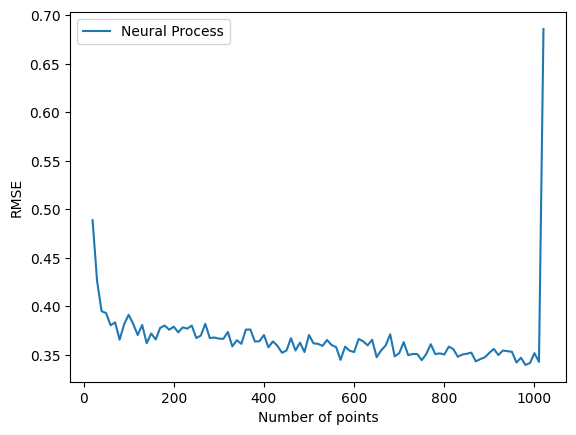

In [ ]:
res = np.load('0np_local.npy')
steps = list(range(20, 20 + acquired_points * acquisition_times + 1, acquired_points))
plt.plot(steps, res, label="Neural Process")
plt.xlabel("Number of points")
plt.ylabel("RMSE")
plt.legend()
plt.savefig("./np_acq_plot.svg")